# DBSCAN Clustering of Quake Tweets

We implement the DBSCAN algorithm in this notebook.

### Imports 

In [1]:
import os
import time
import pandas as pd
import geopandas as gpd
import preprocessor as p
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

### Read in the data

In [2]:
# Set data directory
data_dir = os.path.realpath("../data")

# Check if file exists
if os.path.exists(os.path.join(data_dir, "tweets.h5")):
    # Read tweets from htweets5
    tweets = pd.read_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")
else:
    # Convert tweets to htweets5
    # ? hdf manages large data well
    tweets = pd.read_csv(os.path.join(data_dir, "tweets.csv"))
    tweets.to_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")

### Data Preprocessing

In [3]:
# Remove duplicates
# Test if wikidata column exists
if "wikidata" in tweets.columns:
    tweets.drop_duplicates(subset="wikidata", inplace=True)

# Remove null longitude and latitude values
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
    (tweets.latitude > 42.33278)
    & (tweets.latitude < 51.08917)
    & (tweets.longitude > -4.795556)
    & (tweets.longitude < 8.230556)
]

# Set preprocessor options
p.set_options(p.OPT.URL)

# Remove URLs from the tweets
tweets['text'] = tweets['text'].apply(lambda x: p.clean(x))

# Order tweets by createdAt
tweets.sort_values(by="createdAt", inplace=True)

# Set id as index
tweets["id"] = range(1, len(tweets) + 1)
tweets.set_index('id', inplace=True, verify_integrity=False)

# Remove columns that are not needed
if "wikidata" in tweets.columns:
    tweets.drop(columns=['tweetId', 'mention', 'start', 'end', 'wikidata', 'altitude', 'osm', 'geonames'], inplace=True)

# Convert tweets to geodataframe with crs
tweets = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude), crs="EPSG:4326")

# Convert crs to lambert93
tweets = tweets.to_crs("EPSG:2154")

# Calculate x and y coordinates and round them
tweets['x_m'] = tweets.geometry.x.round(3)
tweets['y_m'] = tweets.geometry.y.round(3)

# Move x_m and y_m after latitude and longitude
tweets = tweets[['text', 'entity', 'x_m', 'y_m', 'createdAt', 'geometry']]

In [4]:
tweets.head()

,text,entity,x_m,y_m,createdAt,geometry
id,,,,,,
1,C'est moi où il y a eu un mini tremblement de ...,Saint-Genest-Malifaux,811188.310,6472179.062,2019-11-11T10:55:21Z,POINT (811188.310 6472179.062)
2,Vous avez senti le tremblement de terre à Pont...,Pont-Saint-Esprit,831602.342,6352192.726,2019-11-11T10:56:12Z,POINT (831602.342 6352192.726)
3,Tremblement de terre à Uzès à l’instant ! Je r...,Uzès,813839.409,6324745.465,2019-11-11T10:56:57Z,POINT (813839.409 6324745.465)
4,Y’a eu un tremblement de terre dans ma ville 😭,Mende (Lozère),739782.346,6380044.618,2019-11-11T10:57:15Z,POINT (739782.346 6380044.618)
5,Petit tremblement de terre sur Oullins de 5’’ ...,Oullins,840602.068,6514341.217,2019-11-11T10:57:44Z,POINT (840602.068 6514341.217)


### Clustering using DBSCAN

In [5]:
# Convert lat and long to numpy array
COORDS = tweets[['x_m', 'y_m']].values

# Set DBSCAN parameters
# ? Higher minsamples or lower eps indicate higher density necessary to form a cluster
# ? On noisy and large datasets, higher min_samples is better
EPS = 20_000 # 20km
MIN_SAMPLES = 5

# Start timer
start = time.time()

# Create DBSCAN model
# ? Noise is labeled -1
db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(COORDS)

# End timer
end = time.time()

# Print time taken
print("Time taken: {} seconds".format(end - start))

# Print number of clusters
print("Number of clusters: {}".format(len(set(db.labels_))))

# Store labels in tweets
tweets['cluster'] = db.labels_

Time taken: 0.006024837493896484 seconds
Number of clusters: 3


### Create convex hulls for each cluster

In [6]:
# Create a hulls geodataframe
hulls = gpd.GeoDataFrame(columns=['cluster', 'num_tweets', 'area_km2', 'geometry'])

for cluster in set(db.labels_):
    if cluster != -1:
        # Get the coordinates of the points in the cluster
        points = COORDS[db.labels_ == cluster]
        # Create a convex hull
        hull = ConvexHull(points)
        # Append the cluster and hull to the geodataframe using concat instead of append
        hulls = pd.concat([hulls, gpd.GeoDataFrame({
            'cluster': [cluster],
            'num_tweets': [len(points)],
            'geometry': [Polygon(points[hull.vertices])]
        })], ignore_index=True)

hulls.set_crs(epsg=2154, inplace=True)

# Calculate the area of the hulls
hulls['area_km2'] = round(hulls['geometry'].area / 1_000_000, 2)

In [7]:
hulls.head()

,cluster,num_tweets,area_km2,geometry
0,0,41,4115.40,"POLYGON ((871472.371 6408004.389, 844235.501 6..."
1,1,17,597.88,"POLYGON ((833082.962 6545423.708, 824587.070 6..."


### Plot the clusters

In [8]:
# Read France geojson
france = gpd.read_file(filename='../data/france.geojson')
france = france.to_crs("EPSG:2154")

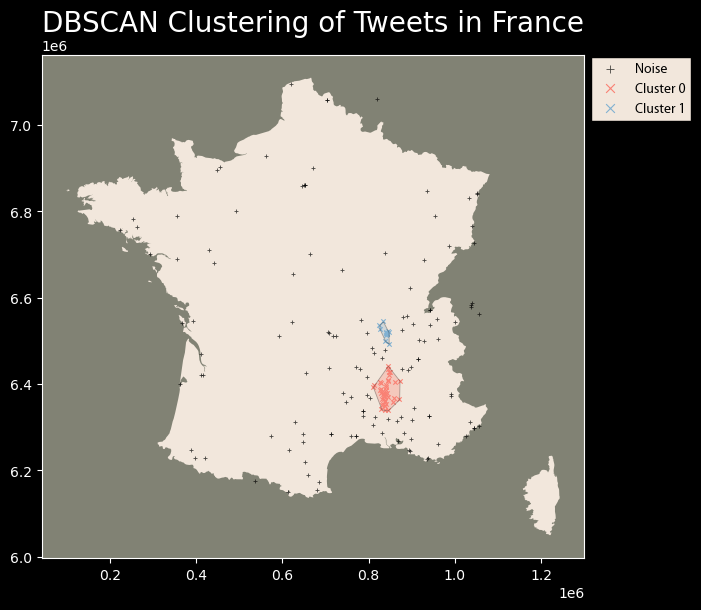

In [9]:
# Plot base map
base = france.plot(color='#F2E7DC', figsize=(7, 7), linewidth=0)
base.set_facecolor('#818274')

# Plot tweets with cluster labels with different markers
for cluster in tweets.cluster.unique():
    tweets[tweets.cluster == cluster].plot(
        ax=base,
        markersize=10,
        label='Noise' if cluster == -1 else 'Cluster {}'.format(cluster),
        alpha=0.7 if cluster == -1 else 1,
        marker='x' if cluster != -1 else '+',
        color='black' if cluster == -1 else 'C{}'.format(cluster + 3),
        linewidth=0.6 if cluster == -1 else 0.8,
    )
    
for cluster in hulls.cluster:
    hulls[hulls.cluster == cluster].plot(
        ax=base,
        alpha=0.3,
        color='C{}'.format(cluster + 3),
        edgecolor='black',
        linewidth=0.6,
    )

# Set title
base.set_title("DBSCAN Clustering of Tweets in France", fontsize=20)

# Set legend
base.legend(loc='best', bbox_to_anchor=(1.21, 1.01), prop={'family': 'Myriad Pro', 'weight': 'book'}, fontsize=9, labelcolor='black', markerscale=2, facecolor='#F2E7DC', edgecolor='black', title_fontsize=14, fancybox=False, framealpha=1)

In [10]:
# Save figure
base.get_figure().savefig('../images/dbscan.png', dpi=300, bbox_inches='tight')